In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
import scipy.io
import datetime, time
import pandas as pd
import my_utils as myf
from matplotlib.gridspec import GridSpec

## Make some plots of AMOC with monthly data

#### Open CESM model output
The files I read in here were created using RAPID-style package from Roberts et al. 2013

In [2]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/moc/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f]
listds = []
for f in myfiles:
    ds = xr.open_dataset(f)[['moc_rapid','ekman']].rename({'moc_rapid':'MOC'})
    myname = str(f.split('/')[-1].split('natl')[0])[:-15]
    mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
    if myname=='CESM1':
        myname = 'CESM1FO'
        mytime = pd.date_range(start="1979-01-01",end="2016-12-31", freq='M')
    ds['time'] = mytime
    ds['names'] = myname
    ds = ds.set_coords('names')
    listds.append(ds)
ds = xr.concat(listds,dim='names')

In [3]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.isel(names=0).copy()
for var in ds:
    lensmean[var] = ds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean =lensmean.set_coords('names')

In [4]:
then = [f for f in ds.names.values if 'nudge' in f and '1950' not in f and 'SH' not in f and '60' not in f]
nmean = ds.isel(names=0).copy()
for var in ds:
    nmean[var] = ds[var].sel(names=then).mean(dim='names')
nmean['names'] = 'NUDGE-ERAI'
nmean =nmean.set_coords('names')

In [5]:
for f in sorted(then):
    print(f)

anom_nudge_era
anom_nudge_era_high
anom_nudge_era_low
nudge_era_MLN_archi
nudge_era_NH_archi_v2
nudge_era_NH_arclo
nudge_era_NH_high
nudge_era_NH_low
nudge_era_archi
nudge_era_arclo
nudge_era_high


In [6]:
rapid = xr.open_dataset('/glade/work/lettier/RAPID/MOCv2021/moc_transports_200404_202039.nc')[['moc_mar_hc10','t_ek10']] # this is daily, take monthly average
rapid_mon = rapid.resample(time='1M').mean('time').rename({'moc_mar_hc10':'MOC',
                                                          't_ek10':'ekman'})
rapid_mon['names'] = 'RAPID'
rapid_mon = rapid_mon.set_coords('names')

In [7]:
ds = xr.concat([ds, nmean, lensmean,rapid_mon],dim='names')

In [8]:
ds['residual'] = ds.MOC - ds.ekman

Set some properties for plotting

In [9]:
lineplotprop = myf.set_line_prop(ds.names.values)

#### Plot model and observations together, with 12 month smoothing

In [10]:
obs_data = ds.sel(names='RAPID')
fo_data = ds.sel(names='CESM1FO')

ds_short = ds.where(obs_data.MOC==obs_data.MOC,drop=True).where(fo_data.MOC==fo_data.MOC,drop=True).rolling(time=12, center=True).mean()
ds_short = ds_short.where(ds_short==ds_short,drop=True)

trend_short, _, _, pval_short, _ = myf.linregress(np.arange(len(ds_short.time)),ds_short.load(),dim='time')
ds_short_detrended = ds_short - trend_short*xr.DataArray(np.arange(len(ds_short.time)), coords={'time':ds_short.time},dims=('time'))
ds_short_detrended_sd = ds_short_detrended.std(dim='time')
corr_short, _ = myf.pearson(ds_short_detrended.sel(names='RAPID'),ds_short_detrended,dim='time')

corr_moc_ekman, _ = myf.pearson(ds_short_detrended.sel(names='RAPID').MOC,ds_short_detrended.ekman,dim='time')

In [11]:
# compute max and min trends from 1000 synthetic time series - RAPID plus random noise with SD of 0.9 Sv
obstimeseries = ds_short.sel(names='RAPID').MOC
rapid_trend = []
for n in range(1000):
    mu, sigma = 0, .9 # mean and standard deviation
    s = np.random.normal(mu, sigma, size=len(obstimeseries))
    t, _, _, _, _ = myf.linregress(np.arange(len(ds_short.time)),(obstimeseries+s).load(),dim='time')
    rapid_trend.append(t)
yerr1 = max(rapid_trend) -trend_short.sel(names='RAPID').MOC  
yerr2 = trend_short.sel(names='RAPID').MOC - min(rapid_trend)

In [12]:
ds_long = ds.sel(names=[f for f in ds.names.values if 'RAPID' not in f]).sel(time=slice('1979','2016'))
trend_long, _, _, pval_long, _ = myf.linregress(np.arange(len(ds_long.time)),ds_long.load(),dim='time')

In [13]:
for name in ['CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI']:
    print(name+', Correlation with RAPID = {:.2f}'.format(corr_short.MOC.sel(names=name).values))

CESM1FO, Correlation with RAPID = 0.83
nudge_era_1950_ens01, Correlation with RAPID = 0.68
NUDGE-ERAI, Correlation with RAPID = 0.78


In [14]:
for name in ['CESM1FO','nudge_era_1950_ens01']:
    print(name+', Correlation with RAPID = {:.2f}'.format(corr_short.ekman.sel(names=name).values))

CESM1FO, Correlation with RAPID = 0.99
nudge_era_1950_ens01, Correlation with RAPID = 0.88


In [15]:
for name in ['CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI','RAPID','LENSmean']:
    print(name+', Magnitude = {:.1f} Sv'.format(ds_short.mean(dim='time').MOC.sel(names=name).values))

CESM1FO, Magnitude = 15.8 Sv
nudge_era_1950_ens01, Magnitude = 14.7 Sv
NUDGE-ERAI, Magnitude = 15.6 Sv
RAPID, Magnitude = 16.9 Sv
LENSmean, Magnitude = 19.2 Sv


In [16]:
for name in ['CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI']:
    print(name+', Corr = {:.2f} '.format(corr_moc_ekman.sel(names=name).values))

CESM1FO, Corr = 0.60 
nudge_era_1950_ens01, Corr = 0.47 
NUDGE-ERAI, Corr = 0.52 


In [17]:
for name in ['CESM1FO','nudge_era_1950_ens01','RAPID','LENSmean']:
    print(name+', Trend = {:.1f} Sv/yr'.format(10.*trend_short.MOC.sel(names=name).values))

CESM1FO, Trend = -0.1 Sv/yr
nudge_era_1950_ens01, Trend = -0.1 Sv/yr
RAPID, Trend = -0.2 Sv/yr
LENSmean, Trend = -0.1 Sv/yr


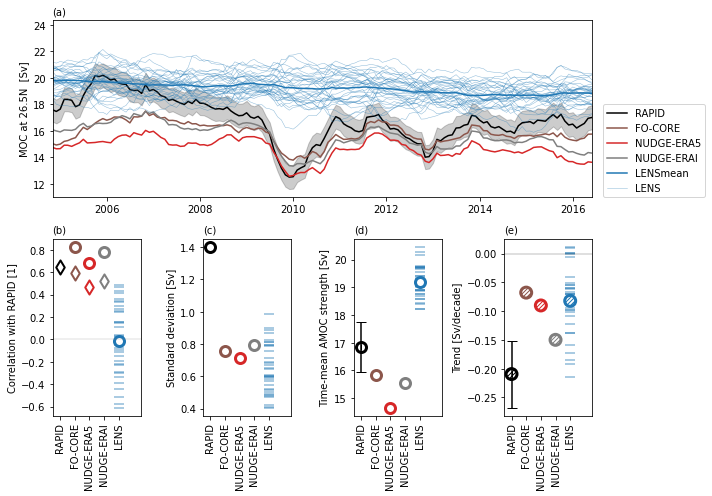

In [18]:
fig = plt.figure(figsize=(10,7))
plot_names = ['RAPID','CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI','LENSmean']
display_plot_names = ['RAPID','FO-CORE','NUDGE-ERA5', 'NUDGE-ERAI','LENS']

spec = fig.add_gridspec(2, 4)
ax = fig.add_subplot(spec[0, :])
for n, name in enumerate(plot_names):
    mydata = ds.rolling(time=12, center=True).mean().MOC.sel(names=name)
    if 'RAPID' in name:
        ax.fill_between(mydata.time.values,mydata-.9,mydata+.9,alpha=.2,color='black')
    ax.plot(mydata.time,mydata, **lineplotprop[name].to_dict()) 
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
        ax.plot(mydata.time,ds.rolling(time=12, center=True).mean().MOC.sel(names=name),
        **lineplotprop[name].to_dict()) 

ax.set_ylabel('MOC at 26.5N  [Sv]')   
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc=(1.02,0))
ax.set_xlim(['2004-11','2016-06'])
ax.set_title('')
ax.set_title('(a)',fontsize=10,loc='left')
ax.set_xlabel('')

########### statistics
ax = fig.add_subplot(spec[1, 2]) ## mag
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
            ax.scatter(4, ds_short.MOC.sel(names=name).squeeze().mean(dim='time'),s=100,
              facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

for n, name in enumerate(plot_names):
    if 'RAPID' in name:
        ax.errorbar(n, ds_short.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze().mean(dim='time'), yerr=.9,
                  c=lineplotprop[name]['c'],marker='|',alpha = lineplotprop[name]['alpha'], capsize=5)

    ax.scatter(n, ds_short.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze().mean(dim='time'), s=100,
                  facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3)
ax.set_xticks(np.arange(len(display_plot_names)))
ax.set_xticklabels(display_plot_names,rotation='vertical')
ax.set_ylabel('Time-mean AMOC strength [Sv]')
ax.set_xlim([-.5,len(plot_names)+.5])
ax.set_title('(d)',fontsize=10,loc='left')

ax= fig.add_subplot(spec[1, 0]) ## correlation
ax.axhline(y=0,c='grey',linewidth=.25)
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
            ax.scatter(4, corr_short.MOC.sel(names=name).squeeze(),s=100,
              facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

for n, name in enumerate(plot_names):
    if 'RAPID' not in name:
        ax.scatter(n, corr_short.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze(), s=100,
              facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3)
    if 'LENS' not in name:
        ax.scatter(n, corr_moc_ekman.sel(names=[f for f in ds.names.values if name in f]).squeeze(),s=100,
              facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='d',alpha = lineplotprop[name]['alpha'],linewidth=2)
       
ax.set_xticks(np.arange(len(display_plot_names)))
ax.set_xticklabels(display_plot_names[:],rotation='vertical')
ax.set_ylabel('Correlation with RAPID [1]')
ax.set_xlim([-.5,len(plot_names)+.5])

ax.set_title('(b)',fontsize=10,loc='left')

ax = fig.add_subplot(spec[1, 1]) ## standard deviation 
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
            ax.scatter(4, ds_short_detrended_sd.MOC.sel(names=name).squeeze(), s=100,
              facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

for n, name in enumerate(plot_names):
    if 'LENSmean' not in name:
        ax.scatter(n, ds_short_detrended_sd.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze(), s=100,
              facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3)
    
ax.set_xticks(np.arange(len(display_plot_names)))
ax.set_xticklabels(display_plot_names,rotation='vertical')
ax.set_ylabel('Standard deviation [Sv]')
ax.set_xlim([-.5,len(plot_names)+.5])
ax.set_title('(c)',fontsize=10,loc='left')

ax = fig.add_subplot(spec[1, 3]) ## trend
ax.set_xticks(np.arange(len(display_plot_names)))
ax.set_xticklabels(display_plot_names,rotation='vertical')
ax.set_ylabel('Trend [Sv/decade]')
ax.set_xlim([-.5,len(plot_names)+.5])
ax.set_title('(e)',fontsize=10,loc='left')

ax.axhline(y=0,c='k',linewidth=.25)
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
            ax.scatter(4, 10.*trend_short.MOC.sel(names=name).squeeze(), s=100,
              facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

for n, name in enumerate(plot_names):
    if 'RAPID' in name:
        ax.errorbar(n, 10.*trend_short.MOC.sel(names=name).squeeze(), yerr=10.*max(yerr2,yerr1),
                  c=lineplotprop[name]['c'],marker='|',alpha = lineplotprop[name]['alpha'], capsize=5)
    hat = '//////'
    if pval_short.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze() > 0.05:
        hat = ''        
    ax.scatter(n, 10.*trend_short.MOC.sel(names=[f for f in ds.names.values if name in f]).squeeze(),s=120,
              facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3, hatch=hat)
 

plt.tight_layout()
fig.savefig('figs/mainFig1.pdf', dpi=500, bbox_inches='tight')
plt.show(); plt.close()

CESM1FO 0.023438202375250582
nudge_era_1950_ens01 -0.01531763287002156
LENSmean -0.04611915834981502


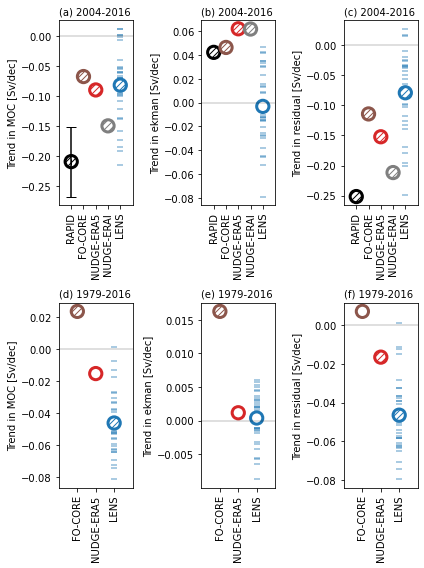

In [19]:
########### statistics
plot_names = ['RAPID','CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI','LENSmean']
display_plot_names = ['RAPID','FO-CORE','NUDGE-ERA5','NUDGE-ERAI','LENS']

fig = plt.figure(figsize=(6,8)) ## trend
for v, var in enumerate(['MOC','ekman','residual']):

    ax = plt.subplot(2,3,v+1)
    ax.axhline(y=0,c='k',linewidth=.25)
    for name in ds.names.values:
        if 'LENS' in name and 'LENSmean' not in name:
                ax.scatter(4, 10.*trend_short[var].sel(names=name).squeeze(),
                  facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

    for n, name in enumerate(plot_names):
        if 'RAPID' in name and var=='MOC':
            ax.errorbar(n, 10.*trend_short[var].sel(names=name).squeeze(), yerr=10.*max(yerr2,yerr1),
                  c=lineplotprop[name]['c'],marker='|',alpha = lineplotprop[name]['alpha'], capsize=5)

        hat = '////'
        if pval_short[var].sel(names=[f for f in ds.names.values if name in f]).squeeze() > 0.05:
            hat = ''

        ax.scatter(n, 10.*trend_short[var].sel(names=[f for f in ds.names.values if name in f]).squeeze(),s=150,
                  facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3, hatch=hat)

    ax.set_xticks(np.arange(len(plot_names)))
    ax.set_xticklabels(display_plot_names,rotation='vertical')
    ax.set_ylabel('Trend in '+var+' [Sv/dec]')
    ax.set_xlim([-1,len(plot_names)])
    ax.set_title(['(a)','(b)','(c)'][v]+' 2004-2016',loc='left',fontsize=10)

########### statistics
plot_names = ['CESM1FO','nudge_era_1950_ens01','LENSmean']
display_plot_names = ['FO-CORE','NUDGE-ERA5','LENS']
for v, var in enumerate(['MOC','ekman','residual']):

    ax = plt.subplot(2,3,3+v+1)
    ax.axhline(y=0,c='k',linewidth=.25)
    for name in ds_long.names.values:
        if 'LENS' in name and 'LENSmean' not in name:
                ax.scatter(2, 10.*trend_long[var].sel(names=name).squeeze(),
                  facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

    for n, name in enumerate(plot_names):
        hat = '////'
        if pval_long[var].sel(names=[f for f in ds_long.names.values if name in f]).squeeze() > 0.05:
            hat = ''
        if var=='MOC':
            print(name,10.*trend_long[var].sel(names=name).values)
              
        ax.scatter(n, 10.*trend_long[var].sel(names=name).squeeze(),s=150,
                  facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3, hatch=hat)

    ax.set_xticks(np.arange(len(plot_names)))
    ax.set_xticklabels(display_plot_names,rotation='vertical')
    ax.set_ylabel('Trend in '+var+' [Sv/dec]')
    ax.set_xlim([-1,len(plot_names)])
    ax.set_title(['(d)','(e)','(f)'][v]+' 1979-2016',loc='left',fontsize=10)

plt.tight_layout()
fig.savefig('figs/suppFig8.pdf', dpi=500, bbox_inches='tight')
plt.show(); plt.close()

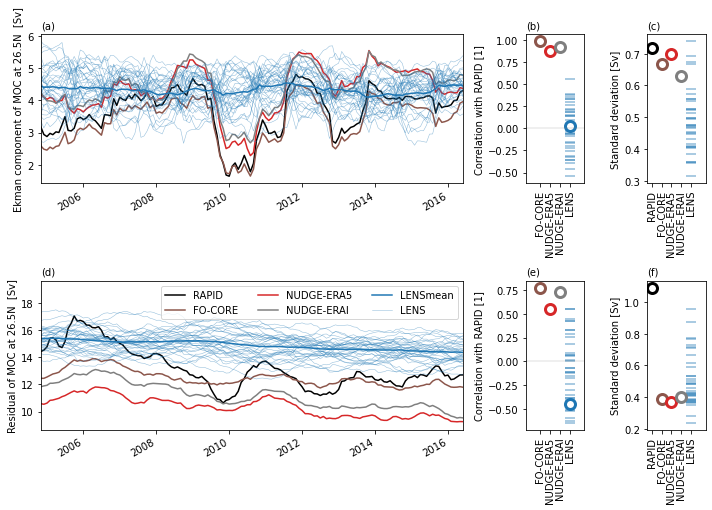

In [20]:
fig = plt.figure(figsize=(10,7))

spec = fig.add_gridspec(2, 6)
ax = fig.add_subplot(spec[0, :4])
plot_names = ['RAPID','CESM1FO','nudge_era_1950_ens01','NUDGE-ERAI','LENSmean']
display_plot_names = ['RAPID','FO-CORE','NUDGE-ERA5','NUDGE-ERAI','LENS']

for n, name in enumerate(plot_names):
        ds.rolling(time=12, center=True).mean().ekman.sel(names=name).plot(ax=ax, **lineplotprop[name].to_dict()) 
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
        ax.plot(mydata.time,ds.rolling(time=12, center=True).mean().ekman.sel(names=name),
        **lineplotprop[name].to_dict()) 

ax.set_ylabel('Ekman component of MOC at 26.5N  [Sv]')   

ax.set_xlim(['2004-11','2016-06'])
ax.set_title('')
ax.set_title('(a)',fontsize=10,loc='left')
ax.set_xlabel('')

ax = fig.add_subplot(spec[1, :4])
for n, name in enumerate(plot_names):
        (ds.MOC-ds.ekman).rolling(time=12, center=True).mean().sel(names=name).plot(ax=ax, **lineplotprop[name].to_dict()) 
for name in ds.names.values:
    if 'LENS' in name and 'LENSmean' not in name:
        ax.plot(mydata.time,(ds.MOC-ds.ekman).rolling(time=12, center=True).mean().sel(names=name),
        **lineplotprop[name].to_dict()) 

ax.set_ylabel('Residual of MOC at 26.5N  [Sv]')   
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=3)
ax.set_xlim(['2004-11','2016-06'])
ax.set_title('')
ax.set_title('(d)',fontsize=10,loc='left')
ax.set_xlabel('')

for c, comp in enumerate(['ekman','residual']):
    ax= fig.add_subplot(spec[c, 4]) ## correlation
    ax.axhline(y=0,c='grey',linewidth=.25)
    for name in ds.names.values:
        if 'LENS' in name and 'LENSmean' not in name:
                ax.scatter(4, corr_short[comp].sel(names=name).squeeze(),s=100,
                  facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

    for n, name in enumerate(plot_names):
        if 'RAPID' not in name:
            ax.scatter(n, corr_short[comp].sel(names=[f for f in ds.names.values if name in f]).squeeze(), s=100,
                  facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3)
         
    ax.set_xticks(np.arange(1,len(display_plot_names),1))
    ax.set_xticklabels(display_plot_names[1:],rotation='vertical')
    ax.set_ylabel('Correlation with RAPID [1]')
    ax.set_xlim([-.5,len(plot_names)+.5])
    ax.set_title(['(b)','(e)'][c],fontsize=10,loc='left')

for c, comp in enumerate(['ekman','residual']):
    ax = fig.add_subplot(spec[c, 5]) ## standard deviation 
    for name in ds.names.values:
        if 'LENS' in name and 'LENSmean' not in name:
                ax.scatter(4, ds_short_detrended_sd[comp].sel(names=name).squeeze(), s=100,
                  facecolor = lineplotprop[name]['c'],marker='_',alpha = lineplotprop[name]['alpha'])

    for n, name in enumerate(plot_names):
        if 'LENSmean' not in name:
            ax.scatter(n, ds_short_detrended_sd[comp].sel(names=[f for f in ds.names.values if name in f]).squeeze(), s=100,
                  facecolor = 'white', edgecolors=lineplotprop[name]['c'],marker='o',alpha = lineplotprop[name]['alpha'],linewidth=3)

    ax.set_xticks(np.arange(len(display_plot_names)))
    ax.set_xticklabels(display_plot_names,rotation='vertical')
    ax.set_ylabel('Standard deviation [Sv]')
    ax.set_xlim([-.5,len(plot_names)+.5])
    ax.set_title(['(c)','(f)'][c],fontsize=10,loc='left')

plt.tight_layout()
fig.savefig('figs/mainFig2.pdf', dpi=500, bbox_inches='tight')
plt.show(); plt.close()